In [13]:
import pandas as pd
import numpy as np
import gymnasium as gym
import random

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
import itertools

from myQwordleEnv import WordleMetaEnv, WordleQEnv, MyAgent
from tqdm import tqdm
import time

In [14]:
f = open('target_words.txt', 'r')
target_words = f.read().splitlines()
f.close()

In [15]:
len(target_words)

2309

We can try a form of Meta-Learning to try to reduce the search space by making the agent learn to choose between few well-defined actions

In [16]:
def Q_Learning(num_episodes, gamma=1.0, alpha=0.5, epsilon=0.1):
    env = WordleMetaEnv(debug=False, word_list_path='target_words.txt')
    actions_len = len(env.action_space)
    Q = defaultdict(lambda: np.zeros(actions_len))
    
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)
    wins = np.zeros(num_episodes)
    
    for i in tqdm(range(num_episodes)):
        state = env.reset()

        # this follows the logic we did in class and extension to an action space of length actions_len by being inspired from the epsilon greedy policy implemented here but for BlackJack: https://github.com/dennybritz/reinforcement-learning/blob/master/MC/MC%20Control%20with%20Epsilon-Greedy%20Policies%20Solution.ipynb
        
        action_probs = np.ones(actions_len, dtype = float) * (epsilon / actions_len)
        action_prob_len = len(action_probs)
        best_action = np.argmax(Q[state])
        action_probs[best_action] = (1.0 - epsilon + (epsilon / actions_len))
        episode_reward = 0
        episode_length = 0
        
        while True:
            # choose action index according to the probability distribution
            action = np.random.choice(np.arange(action_prob_len), p = action_probs / np.sum(action_probs)) # so that probs add up to one
            next, reward, done = env.step(action)
            episode_reward += reward

            opt_action = np.argmax(Q[next])

            #Q(s,a) ← Q(s,a) + α[ r + γ·max Q(s',a') - Q(s,a) ] 

            # temporal differences

            new_info = reward + gamma * Q[next][opt_action]
            oldQsa = Q[state][action]
            Q[state][action] += alpha * ( new_info - oldQsa)

            if done:
                episode_lengths[i] = episode_length + 1
                episode_rewards[i] = episode_reward
                if env.env.won_game == 'yes':
                    wins[i] = 1
                elif env.env.won_game == 'no':
                    wins[i] = 0
                    episode_lengths[i] = 7
                    
                break
                
            state = next
            episode_length += 1

            
    return Q, (episode_lengths, episode_rewards, wins)

In [17]:
def plot_game_statistics(stats, window_size=500):
    
    episode_lengths = stats[0]
    episode_rewards = stats[1]
    win_records = stats[2]
    num_episodes = len(episode_lengths)
    
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    
    if num_episodes > window_size:
        ma_lengths = moving_average(episode_lengths, window_size)
        ma_rewards = moving_average(episode_rewards, window_size)
        ma_wins = moving_average(win_records, window_size)
        x_range = np.arange(window_size-1, num_episodes)
    else:
        ma_lengths = episode_lengths
        ma_rewards = episode_rewards
        ma_wins = win_records
        x_range = np.arange(num_episodes)
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    ax1.plot(x_range, ma_lengths, 'steelblue', linewidth=2)
    ax1.set_title('Wordle Game Lengths Over Time', fontsize=16)
    ax1.set_ylabel('Number of Guesses', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(x_range, ma_rewards, 'forestgreen', linewidth=2)
    ax2.set_title('Wordle Game Rewards Over Time', fontsize=16)
    ax2.set_ylabel('Total Reward', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    ax3.plot(x_range, ma_wins, 'darkorange', linewidth=2)
    ax3.set_title('Wordle Win Rate Over Time', fontsize=16)
    ax3.set_ylabel('Win Rate', fontsize=14)
    ax3.set_xlabel('Episode', fontsize=14)
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    labels, counts = np.unique(episode_lengths, return_counts=True)
    plt.bar(labels, counts, align='center', color='steelblue')
    plt.xlabel('Game Length (Number of Guesses)', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of Wordle Game Lengths', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.xticks(labels)
    plt.show()
    
    win_percentage = np.mean(win_records) * 100
    
    print(f"Win Rate: {win_percentage:.2f}%")
    print(f"Average Game Length: {np.mean(episode_lengths):.2f} guesses")
    print(f"Average Reward: {np.mean(episode_rewards):.2f}")
    
    if np.sum(win_records) > 0:
        win_lengths = episode_lengths[win_records == 1]
        plt.figure(figsize=(10, 6))
        win_labels, win_counts = np.unique(win_lengths, return_counts=True)
        plt.bar(win_labels, win_counts, align='center', color='forestgreen')
        plt.xlabel('Game Length for Wins (Number of Guesses)', fontsize=14)
        plt.ylabel('Count', fontsize=14)
        plt.title('Distribution of Game Lengths for Wins', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.xticks(win_labels)
        plt.show()

100%|██████████| 50000/50000 [07:39<00:00, 108.84it/s]


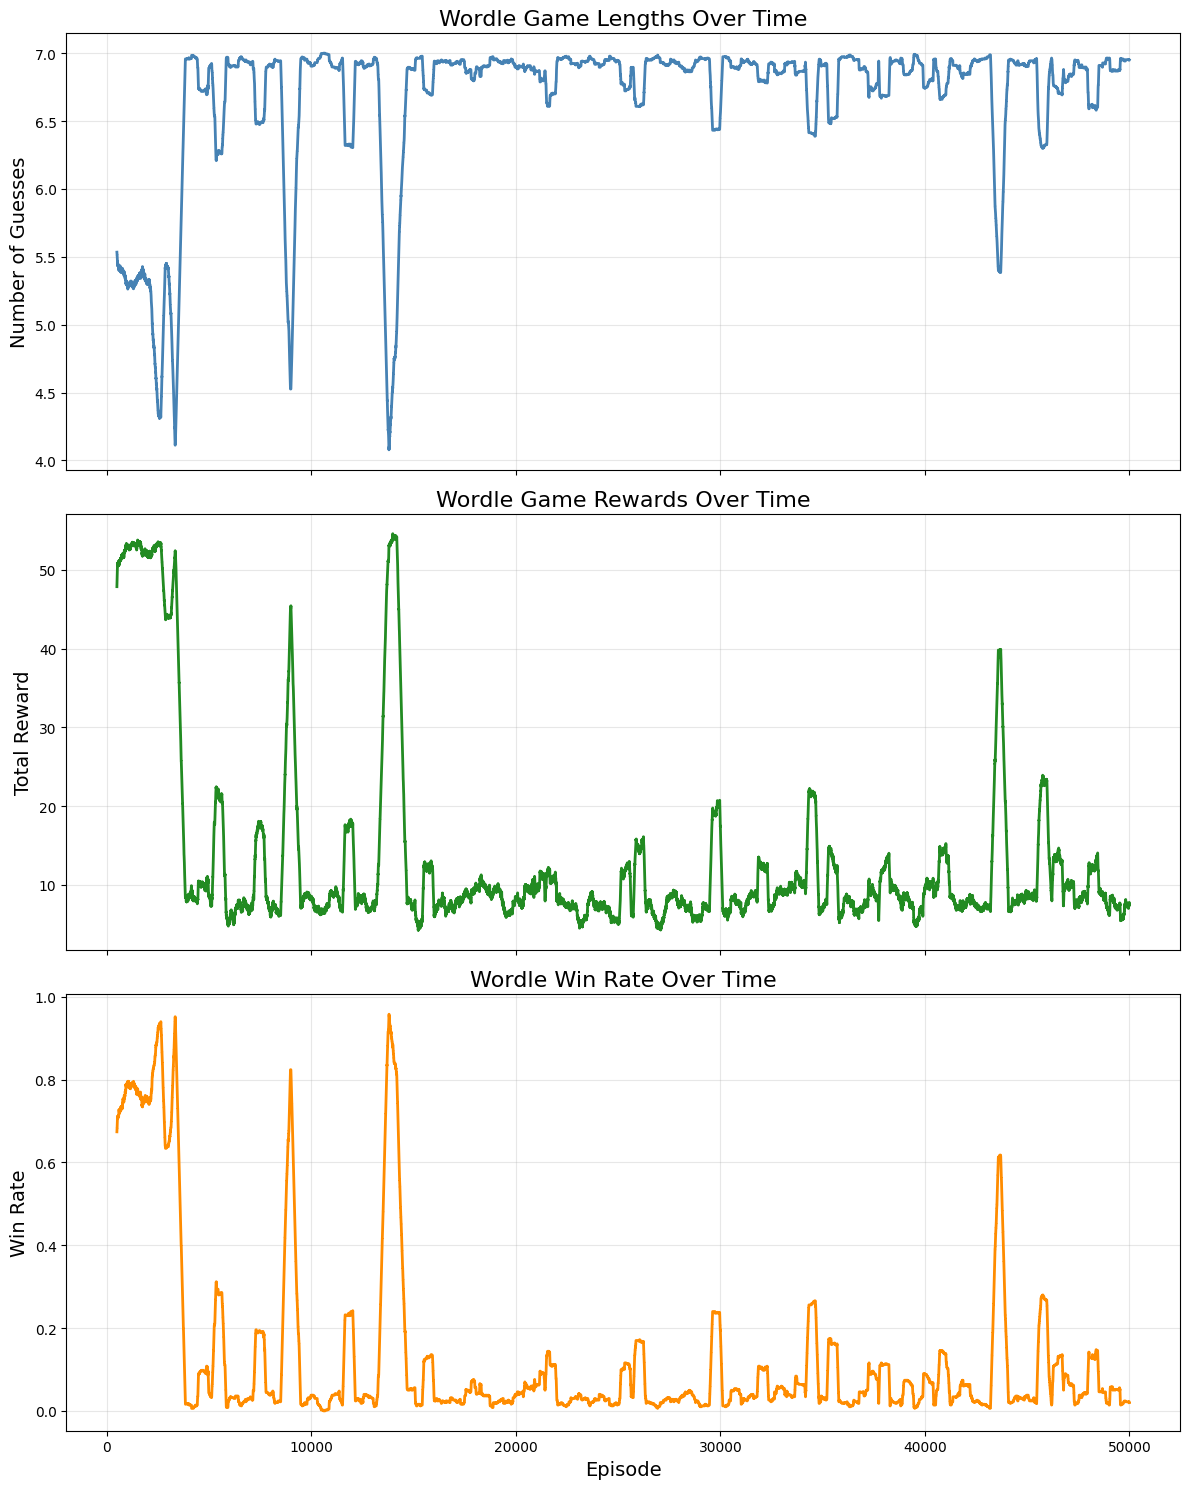

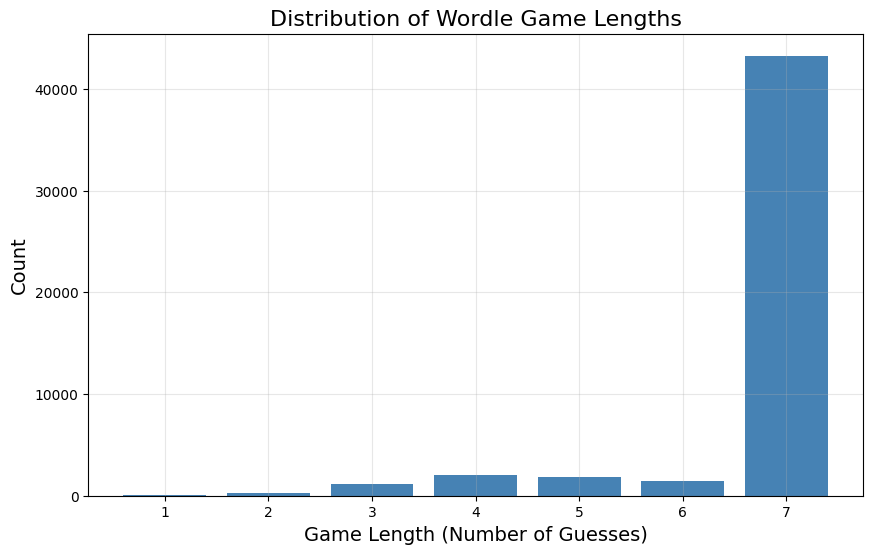

Win Rate: 13.48%
Average Game Length: 6.66 guesses
Average Reward: 13.43


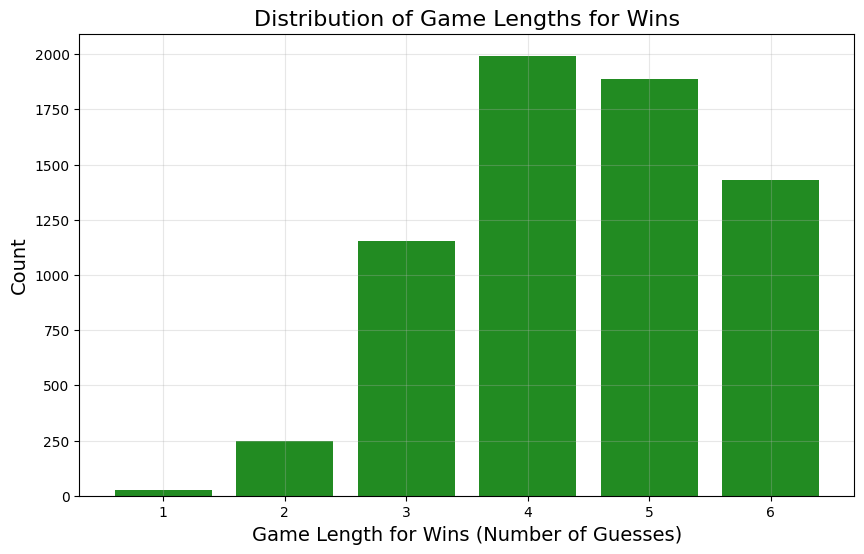

In [18]:
def train_and_evaluate(num_episodes=50000, epsilon=0.1, alpha=0.05, gamma=0.5):
    return Q_Learning(num_episodes=num_episodes, epsilon=epsilon, alpha=alpha, gamma=gamma)

Q, training_details = train_and_evaluate(num_episodes=50000)
plot_game_statistics(training_details)

In [19]:
import pickle
with open('Q_table_intermediate_final.pkl', 'wb') as f:
    pickle.dump(dict(Q), f)
# load it
with open('Q_table_intermediate_final.pkl', 'rb') as f:
    Q_loaded = pickle.load(f)

100%|██████████| 2309/2309 [00:08<00:00, 257.62it/s]


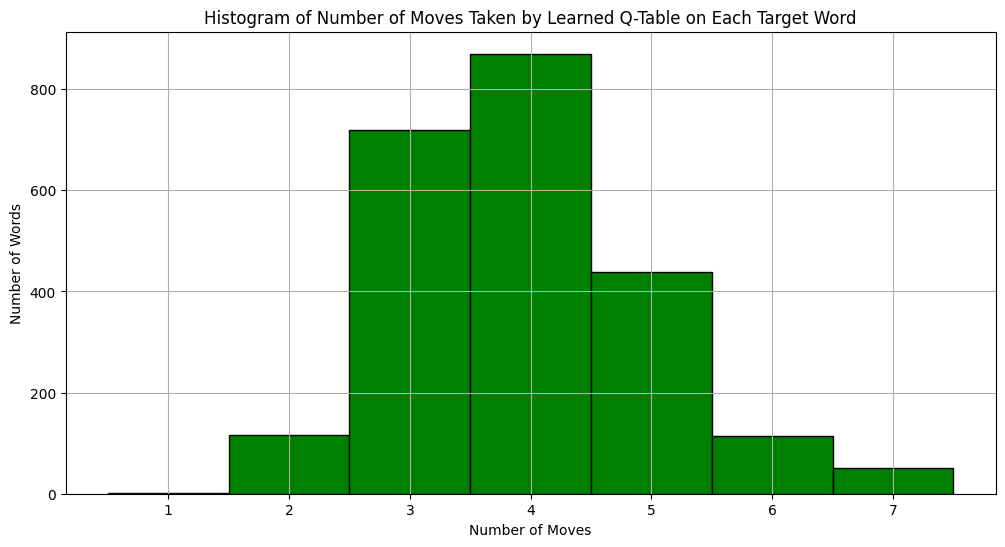

In [20]:
def run_episode_for_target(target, Q):
    env = WordleMetaEnv(debug=False, word_list_path='target_words.txt')
    env.reset()
    env.env.target_word = target  
    env.env.attempts = 0  
    env.env.guessed_words = []
    
    done = False
    state = (0, 0, 0)
    moves = 0


    while not done:
        if state in Q:
            action = np.argmax(Q[state])
        else:
            action = random.choice(env.agent.action_space)
            
        state, reward, done = env.step(action)
        moves += 1
    if env.env.won_game == 'yes':
        return moves
    else:
        env.env.won_game = 'no'
        return moves+1


moves_list = []
f = open('target_words.txt', 'r')
new_target_words = f.read().splitlines()
f.close()
for word in tqdm(new_target_words):
    m = run_episode_for_target(word, Q_loaded)
    moves_list.append(m)

plt.figure(figsize=(12, 6))
plt.hist(moves_list, bins=range(1, max(moves_list) + 2), edgecolor='black', color='green', align='left')
plt.xlabel("Number of Moves")
plt.ylabel("Number of Words")
plt.title("Histogram of Number of Moves Taken by Learned Q-Table on Each Target Word")
plt.xticks(range(1, max(moves_list) + 1))
plt.grid(True)
plt.show()

In [21]:
print("Average game length:", np.mean(moves_list))

Average game length: 3.9398007795582504


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import pandas as pd
from tqdm import tqdm

action_names = [
    "Random",
    "Rand_Not_Absent",
    "Rand_Green_Not_Absent",
    "Letter_Frequency",
    "Smart_Guess",
    "Yellow_Position_Tracking"
]

# First, let's analyze the Q-table
def analyze_q_table(Q):
    # Extract all states and their values
    states = list(Q.keys())
    
    # Get the distribution of best actions for each state
    best_actions = [np.argmax(Q[state]) for state in states]
    action_counts = np.bincount(best_actions, minlength=6)
    
    # Action names for better readability
    action_names = [
        "Random",
        "Rand_Not_Absent",
        "Rand_Green_Not_Absent",
        "Letter_Frequency",
        "Smart_Guess",
        "Yellow_Position_Tracking"
    ]
    
    # Create a dataframe for better analysis
    state_df = pd.DataFrame([
        {'state': state, 
         'greens': state[0], 
         'yellows': state[1], 
         'blacks': state[2], 
         'best_action': np.argmax(Q[state]),
         'best_action_name': action_names[np.argmax(Q[state])],
         'best_q_value': np.max(Q[state]),
         'q_values': Q[state].tolist()}
        for state in states
    ])
    
    return state_df, action_counts, action_names

# Visualize best actions distribution
def plot_action_distribution(action_counts, action_names):
    plt.figure(figsize=(10, 6))
    plt.bar(action_names, action_counts)
    plt.title('Distribution of Best Actions Across All States')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('action_distribution.png')
    plt.close()
    
    print("Action distribution:")
    for i, (name, count) in enumerate(zip(action_names, action_counts)):
        percentage = (count / sum(action_counts)) * 100
        print(f"{i}: {name}: {count} states ({percentage:.2f}%)")

# Visualize best actions by game state progress
def plot_actions_by_game_progress(state_df):
    # Create a progress metric: greens are good progress, yellows are medium
    state_df['progress_score'] = state_df['greens'] * 3 + state_df['yellows']
    
    # Group by progress score
    progress_groups = state_df.groupby('progress_score')
    
    # Prepare data for action distribution by progress
    progress_data = []
    for progress, group in progress_groups:
        action_dist = np.bincount(group['best_action'].values, minlength=6)
        action_dist = action_dist / action_dist.sum()  # Normalize
        for i, prob in enumerate(action_dist):
            progress_data.append({
                'progress_score': progress,
                'action': i,
                'action_name': action_names[i],
                'probability': prob
            })
    
    progress_df = pd.DataFrame(progress_data)
    
    # Plot heatmap of action probability by progress
    pivot_df = progress_df.pivot(index='progress_score', columns='action_name', values='probability')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, cmap="YlGnBu", annot=True, fmt=".2f")
    plt.title('Action Selection Probability by Game Progress')
    plt.ylabel('Progress Score (3*Greens + Yellows)')
    plt.xlabel('Action')
    plt.tight_layout()
    plt.savefig('action_by_progress.png')
    plt.close()

# Visualize Q-values by game state
def plot_q_values_by_state_features(state_df):
    # Q-values by number of greens
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='greens', y='best_q_value', data=state_df)
    plt.title('Best Q-values by Number of Green Letters')
    plt.xlabel('Number of Green Letters')
    plt.ylabel('Best Q-value')
    plt.tight_layout()
    plt.savefig('q_values_by_greens.png')
    plt.close()
    
    # Q-values by number of yellows
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='yellows', y='best_q_value', data=state_df)
    plt.title('Best Q-values by Number of Yellow Letters')
    plt.xlabel('Number of Yellow Letters')
    plt.ylabel('Best Q-value')
    plt.tight_layout()
    plt.savefig('q_values_by_yellows.png')
    plt.close()
    
    # Q-values by number of blacks
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='blacks', y='best_q_value', data=state_df)
    plt.title('Best Q-values by Number of Black Letters')
    plt.xlabel('Number of Black Letters')
    plt.ylabel('Best Q-value')
    plt.tight_layout()
    plt.savefig('q_values_by_blacks.png')
    plt.close()

# Visualize which actions are preferred in different stages of the game
def plot_action_preferences_by_game_stage(state_df):
    # Define early, mid, and late game based on greens
    state_df['game_stage'] = pd.cut(
        state_df['greens'], 
        bins=[-1, 1, 3, 5], 
        labels=['Early Game', 'Mid Game', 'Late Game']
    )
    
    # Group by game stage and count action preferences
    stage_action_counts = state_df.groupby(['game_stage', 'best_action_name']).size().reset_index(name='count')
    
    # Pivot for plotting
    stage_pivot = stage_action_counts.pivot(index='game_stage', columns='best_action_name', values='count')
    stage_pivot = stage_pivot.fillna(0)
    
    # Normalize to get percentages
    stage_pivot = stage_pivot.div(stage_pivot.sum(axis=1), axis=0) * 100
    
    # Plot
    plt.figure(figsize=(12, 8))
    stage_pivot.plot(kind='bar', stacked=True)
    plt.title('Action Preferences by Game Stage')
    plt.xlabel('Game Stage')
    plt.ylabel('Percentage of States')
    plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('action_by_game_stage.png')
    plt.close()

# Evaluate the learned policy
def evaluate_policy(Q, num_episodes=1000):
    from myQwordleEnv import WordleMetaEnv
    
    env = WordleMetaEnv()
    
    episode_lengths = []
    wins = 0
    action_counts = np.zeros(6)
    state_action_history = []
    
    for i in tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        
        while not done:
            # Choose best action according to Q
            action = np.argmax(Q[state])
            action_counts[action] += 1
            
            # Record state and action
            state_action_history.append({
                'greens': state[0],
                'yellows': state[1],
                'blacks': state[2],
                'action': action
            })
            
            # Take step
            next_state, reward, done = env.step(action)
            state = next_state
        
        episode_lengths.append(env.guesses_made)
        if env.env.won_game == 'yes':
            wins += 1
    
    win_rate = wins / num_episodes * 100
    avg_guesses = sum(episode_lengths) / num_episodes
    
    print(f"Win rate: {win_rate:.2f}%")
    print(f"Average guesses: {avg_guesses:.2f}")
    
    # Plot action frequency during evaluation
    action_names = [
        "Random",
        "Rand_Not_Absent",
        "Rand_Green_Not_Absent",
        "Letter_Frequency",
        "Smart_Guess",
        "Yellow_Position_Tracking"
    ]
    
    plt.figure(figsize=(10, 6))
    plt.bar(action_names, action_counts)
    plt.title('Action Frequency During Evaluation')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('evaluation_action_frequency.png')
    plt.close()
    
    # Create a DataFrame with the evaluation history
    eval_df = pd.DataFrame(state_action_history)
    
    return win_rate, avg_guesses, eval_df, action_counts

# Function to run all analyses
def run_analysis(Q):
    print("Analyzing Q-table...")
    state_df, action_counts, action_names = analyze_q_table(Q)
    
    print("\nPlotting action distribution...")
    plot_action_distribution(action_counts, action_names)
    
    print("\nPlotting actions by game progress...")
    plot_actions_by_game_progress(state_df)
    
    print("\nPlotting Q-values by state features...")
    plot_q_values_by_state_features(state_df)
    
    print("\nPlotting action preferences by game stage...")
    plot_action_preferences_by_game_stage(state_df)
    
    print("\nEvaluating learned policy...")
    win_rate, avg_guesses, eval_df, eval_action_counts = evaluate_policy(Q)
    
    # Plot action distribution at different game turns
    eval_df['turn'] = eval_df.groupby(eval_df.index // 6).cumcount() + 1
    
    # Plot action distribution by turn
    turn_action_pivot = pd.crosstab(
        index=eval_df['turn'], 
        columns=eval_df['action'],
        normalize='index'
    ) * 100
    
    action_names = [
        "Random",
        "Rand_Not_Absent",
        "Rand_Green_Not_Absent",
        "Letter_Frequency",
        "Smart_Guess",
        "Yellow_Position_Tracking"
    ]
    # Ensure the number of columns matches the number of action names
    if turn_action_pivot.shape[1] == len(action_names):
        turn_action_pivot.columns = action_names
    else:
        print(f"Warning: Expected {turn_action_pivot.shape[1]} action names, but got {len(action_names)}. Skipping renaming.")
    
    plt.figure(figsize=(12, 8))
    turn_action_pivot.plot(kind='bar', stacked=True)
    plt.title('Action Distribution by Turn')
    plt.xlabel('Turn')
    plt.ylabel('Percentage')
    plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('action_by_turn.png')
    plt.close()
    
    # Plot first action distribution
    first_actions = eval_df[eval_df['turn'] == 1]['action'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    plt.bar([action_names[i] for i in first_actions.index], first_actions.values)
    plt.title('First Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('first_action_distribution.png')
    plt.close()
    
    # Return analysis results
    return {
        'state_df': state_df,
        'action_counts': action_counts,
        'win_rate': win_rate,
        'avg_guesses': avg_guesses,
        'eval_df': eval_df
    }

# Function to analyze learning performance
def analyze_learning_performance(training_details):
    episode_lengths, episode_rewards, wins = training_details
    
    # Plot episode lengths
    plt.figure(figsize=(10, 6))
    plt.plot(episode_lengths)
    plt.title('Episode Lengths During Training')
    plt.xlabel('Episode')
    plt.ylabel('Length')
    plt.ylim(0, 8)
    plt.grid(True)
    plt.savefig('episode_lengths.png')
    plt.close()
    
    # Plot episode rewards
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards)
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.savefig('episode_rewards.png')
    plt.close()
    
    # Plot win rate over time
    window_size = 1000
    if len(wins) >= window_size:
        win_rates = []
        for i in range(0, len(wins) - window_size + 1, window_size // 10):
            win_rate = np.mean(wins[i:i+window_size]) * 100
            win_rates.append((i + window_size // 2, win_rate))
        
        plt.figure(figsize=(10, 6))
        plt.plot([x[0] for x in win_rates], [x[1] for x in win_rates])
        plt.title(f'Win Rate Over Time (Window Size: {window_size})')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate (%)')
        plt.grid(True)
        plt.savefig('win_rate_over_time.png')
        plt.close()

# Main analysis function
def main_analysis(Q, training_details):
    # Run Q-table analysis
    analysis_results = run_analysis(Q)
    
    # Analyze learning performance
    analyze_learning_performance(training_details)
    
    return analysis_results

# Usage example:
results = main_analysis(Q, training_details)

Analyzing Q-table...

Plotting action distribution...
Action distribution:
0: Random: 1 states (4.55%)
1: Rand_Not_Absent: 0 states (0.00%)
2: Rand_Green_Not_Absent: 2 states (9.09%)
3: Letter_Frequency: 1 states (4.55%)
4: Smart_Guess: 6 states (27.27%)
5: Yellow_Position_Tracking: 12 states (54.55%)

Plotting actions by game progress...

Plotting Q-values by state features...


/var/folders/fd/pqhldq7s46j4zcbt6_zktcnh0000gn/T/ipykernel_12578/2393276154.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stage_action_counts = state_df.groupby(['game_stage', 'best_action_name']).size().reset_index(name='count')



Plotting action preferences by game stage...

Evaluating learned policy...


100%|██████████| 1000/1000 [00:03<00:00, 256.12it/s]


Win rate: 98.60%
Average guesses: 3.94


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [23]:
import os
import seaborn as sns
# This function evaluates the Q-table on a specific list of target words
def evaluate_on_word_list(Q, word_list_path='target_words.txt', output_dir='evaluation_results'):
    """
    Evaluate Q-learning policy on a specific list of words
    
    Args:
        Q: The learned Q-table
        word_list_path: Path to file containing target words
        output_dir: Directory to save results and plots
    
    Returns:
        DataFrame with evaluation results
    """
    from myQwordleEnv import WordleQEnv, MyAgent
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Read the word list
    with open(word_list_path, 'r') as f:
        words = f.read().splitlines()
    
    # Define action names for better readability
    action_names = [
        "Random",
        "Rand_Not_Absent",
        "Rand_Green_Not_Absent",
        "Letter_Frequency",
        "Smart_Guess",
        "Yellow_Position_Tracking"
    ]
    
    # Initialize results storage
    results = []
    all_actions_taken = []
    
    # Evaluate each word
    for target_word in tqdm(words, desc="Evaluating words"):
        # Initialize environment with specific target word
        env = WordleQEnv()
        env.target_word = target_word
        agent = MyAgent()
        
        state = (0, 0, 0)  # Initial state: no greens, yellows, or blacks
        done = False
        guesses = []
        actions_taken = []
        
        # Play the game using the learned policy
        while not done:
            # Choose best action according to Q-table
            action = np.argmax(Q[state])
            actions_taken.append(action)
            
            # Take the action based on the strategy
            if action == 0:
                guess = agent.randomly()
            elif action == 1:
                guess = agent.rand_not_absent(env.letters_absent)
            elif action == 2:
                guess = agent.rand_green_not_absent(env.pos_guessed_correctly, env.letters_absent)
            elif action == 3:
                guess = agent.letter_frequency_guess()
            elif action == 4:
                guess = agent.smart_guess(green_positions=env.pos_guessed_correctly, 
                                         yellows=env.letters_present, 
                                         absent_letters=env.letters_absent)
            elif action == 5:
                guess = agent.yellow_position_tracking(yellows=env.letters_present, 
                                                     absent_letters=env.letters_absent,
                                                     yellow_positions=env.pos_yellow, 
                                                     green_positions=env.pos_guessed_correctly)
            
            # Make the guess and observe result
            greens, yellows, blacks = env.make_guess(guess)
            guesses.append(guess)
            
            # Update state
            next_state = (greens, yellows, blacks)
            
            # Check if game is over
            if env.won_game == "yes":
                success = True
                done = True
            elif env.attempts >= env.max_attempts:
                success = False
                done = True
            else:
                state = next_state
        
        # Record results for this word
        word_result = {
            "target_word": target_word,
            "success": success,
            "num_guesses": len(guesses),
            "guesses": guesses,
            "actions": actions_taken,
            "unique_actions": len(set(actions_taken)),
            "final_state": state
        }
        results.append(word_result)
        
        # Add to total actions list with turn information
        for turn, action in enumerate(actions_taken, 1):
            all_actions_taken.append({
                "target_word": target_word,
                "turn": turn,
                "action": action,
                "action_name": action_names[action]
            })
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    actions_df = pd.DataFrame(all_actions_taken)
    
    # Analyze and visualize results
    analyze_results(results_df, actions_df, action_names, output_dir)
    
    return results_df, actions_df

def analyze_results(results_df, actions_df, action_names, output_dir):
    """
    Analyze and visualize evaluation results
    
    Args:
        results_df: DataFrame with evaluation results for each target word
        actions_df: DataFrame with all actions taken during evaluation
        action_names: List of action names
        output_dir: Directory to save plots
    """
    # 1. Overall Performance Metrics
    success_rate = results_df['success'].mean() * 100
    avg_guesses = results_df['num_guesses'].mean()
    avg_guesses_success = results_df[results_df['success']]['num_guesses'].mean()
    
    print(f"Success Rate: {success_rate:.2f}%")
    print(f"Average Guesses: {avg_guesses:.2f}")
    print(f"Average Guesses (Successful games): {avg_guesses_success:.2f}")
    
    # Save metrics to file
    with open(f"{output_dir}/performance_metrics.txt", "w") as f:
        f.write(f"Success Rate: {success_rate:.2f}%\n")
        f.write(f"Average Guesses: {avg_guesses:.2f}\n")
        f.write(f"Average Guesses (Successful games): {avg_guesses_success:.2f}\n")
    
    # 2. Distribution of Number of Guesses
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['num_guesses'], discrete=True, kde=False)
    plt.title('Distribution of Number of Guesses')
    plt.xlabel('Number of Guesses')
    plt.ylabel('Count')
    plt.xticks(range(1, 8))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{output_dir}/guess_distribution.png")
    plt.close()
    
    # 3. Success Rate by Number of Guesses
    success_by_guesses = results_df.groupby('num_guesses')['success'].mean() * 100
    plt.figure(figsize=(10, 6))
    success_by_guesses.plot(kind='bar')
    plt.title('Success Rate by Number of Guesses')
    plt.xlabel('Number of Guesses')
    plt.ylabel('Success Rate (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{output_dir}/success_by_guesses.png")
    plt.close()
    
    # 4. Distribution of Actions Taken
    action_counts = actions_df['action'].value_counts().sort_index()
    plt.figure(figsize=(12, 6))
    plt.bar([action_names[i] for i in action_counts.index], action_counts.values)
    plt.title('Distribution of Actions Taken')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/action_distribution.png")
    plt.close()
    
    # 5. Actions by Turn
    turn_action_counts = pd.crosstab(index=actions_df['turn'], columns=actions_df['action'])
    turn_action_counts.columns = [action_names[i] for i in turn_action_counts.columns]
    
    # Calculate percentages
    turn_action_pct = turn_action_counts.div(turn_action_counts.sum(axis=1), axis=0) * 100
    
    plt.figure(figsize=(14, 8))
    turn_action_pct.plot(kind='bar', stacked=True, colormap='viridis')
    plt.title('Action Distribution by Turn')
    plt.xlabel('Turn')
    plt.ylabel('Percentage')
    plt.legend(title='Action', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/action_by_turn.png")
    plt.close()
    
    # 6. Number of Unique Actions Used
    plt.figure(figsize=(10, 6))
    sns.histplot(results_df['unique_actions'], discrete=True, kde=False)
    plt.title('Distribution of Unique Actions Used Per Word')
    plt.xlabel('Number of Unique Actions')
    plt.ylabel('Count')
    plt.xticks(range(1, 7))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{output_dir}/unique_actions_distribution.png")
    plt.close()
    
    # 7. Success Rate by Unique Actions Used
    success_by_unique = results_df.groupby('unique_actions')['success'].mean() * 100
    plt.figure(figsize=(10, 6))
    success_by_unique.plot(kind='bar')
    plt.title('Success Rate by Number of Unique Actions Used')
    plt.xlabel('Number of Unique Actions')
    plt.ylabel('Success Rate (%)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f"{output_dir}/success_by_unique_actions.png")
    plt.close()
    
    # 8. Heatmap of Action Transitions
    action_transitions = []
    for _, row in results_df.iterrows():
        actions = row['actions']
        if len(actions) < 2:
            continue
        for i in range(len(actions) - 1):
            action_transitions.append((actions[i], actions[i+1]))
    
    transition_df = pd.DataFrame(action_transitions, columns=['from', 'to'])
    transition_counts = pd.crosstab(index=transition_df['from'], columns=transition_df['to'])
    
    # Fill missing values with 0
    for i in range(6):
        if i not in transition_counts.index:
            transition_counts.loc[i] = 0
        if i not in transition_counts.columns:
            transition_counts[i] = 0
    
    transition_counts = transition_counts.sort_index(axis=0).sort_index(axis=1)
    
    # Calculate percentages for better visualization
    transition_pct = transition_counts.div(transition_counts.sum(axis=1), axis=0) * 100
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(transition_pct, annot=True, fmt=".1f", cmap="YlGnBu",
                xticklabels=action_names, yticklabels=action_names)
    plt.title('Action Transition Probabilities (%)')
    plt.xlabel('To Action')
    plt.ylabel('From Action')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/action_transitions.png")
    plt.close()
    
    # 9. First Action Distribution
    first_actions = actions_df[actions_df['turn'] == 1]['action'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    plt.bar([action_names[i] for i in first_actions.index], first_actions.values)
    plt.title('First Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/first_action_distribution.png")
    plt.close()
    
    # 10. Performance comparison by first action
    first_action_results = pd.merge(
        actions_df[actions_df['turn'] == 1][['target_word', 'action']], 
        results_df[['target_word', 'success', 'num_guesses']], 
        on='target_word'
    )
    first_action_results['action_name'] = first_action_results['action'].map(
        {i: name for i, name in enumerate(action_names)}
    )
    
    # Success rate by first action
    success_by_first = first_action_results.groupby('action_name')['success'].mean() * 100
    plt.figure(figsize=(12, 6))
    success_by_first.plot(kind='bar')
    plt.title('Success Rate by First Action')
    plt.xlabel('First Action')
    plt.ylabel('Success Rate (%)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/success_by_first_action.png")
    plt.close()
    
    # Average guesses by first action
    guesses_by_first = first_action_results.groupby('action_name')['num_guesses'].mean()
    plt.figure(figsize=(12, 6))
    guesses_by_first.plot(kind='bar')
    plt.title('Average Number of Guesses by First Action')
    plt.xlabel('First Action')
    plt.ylabel('Average Number of Guesses')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/guesses_by_first_action.png")
    plt.close()
    
    # 11. Word difficulty analysis
    # Sort words by success and number of guesses
    word_difficulty = results_df[['target_word', 'success', 'num_guesses']].copy()
    word_difficulty['difficulty'] = word_difficulty['num_guesses']
    word_difficulty.loc[~word_difficulty['success'], 'difficulty'] = 7  # Unsuccessful attempts get highest difficulty
    
    # Get most difficult and easiest words
    n_words = min(20, len(word_difficulty))
    hardest_words = word_difficulty.sort_values('difficulty', ascending=False).head(n_words)
    easiest_words = word_difficulty.sort_values(['difficulty', 'target_word']).head(n_words)
    
    # Save to CSV
    hardest_words.to_csv(f"{output_dir}/hardest_words.csv", index=False)
    easiest_words.to_csv(f"{output_dir}/easiest_words.csv", index=False)
    
    # Plot hardest words
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='target_word', y='difficulty', hue='success', data=hardest_words)
    plt.title(f'Top {n_words} Most Difficult Words')
    plt.xlabel('Word')
    plt.ylabel('Difficulty (Number of Guesses, 7 if failed)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/hardest_words.png")
    plt.close()
    
    # 12. Letter frequency analysis
    # Analyze if certain letters make words harder
    letter_difficulty = {}
    for _, row in results_df.iterrows():
        word = row['target_word']
        difficulty = row['num_guesses'] if row['success'] else 7
        
        # Count each letter's contribution to difficulty
        for letter in set(word):  # Using set to count each unique letter once
            if letter not in letter_difficulty:
                letter_difficulty[letter] = {'count': 0, 'total_difficulty': 0}
            letter_difficulty[letter]['count'] += 1
            letter_difficulty[letter]['total_difficulty'] += difficulty
    
    # Calculate average difficulty for each letter
    letter_df = pd.DataFrame([
        {'letter': letter, 
         'count': data['count'], 
         'avg_difficulty': data['total_difficulty'] / data['count']}
        for letter, data in letter_difficulty.items()
    ])
    
    # Sort by average difficulty
    letter_df = letter_df.sort_values('avg_difficulty', ascending=False)
    
    # Plot letters by difficulty
    plt.figure(figsize=(14, 8))
    sns.barplot(x='letter', y='avg_difficulty', data=letter_df, hue='count', palette='viridis', dodge=False)
    plt.title('Average Word Difficulty by Letter')
    plt.xlabel('Letter')
    plt.ylabel('Average Difficulty')
    plt.legend(title='Word Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/letter_difficulty.png")
    plt.close()
    
    return

# Run evaluation on a specific word list
def run_word_evaluation(Q, word_list_path='target_words.txt', sample_size=None):
    """
    Run evaluation on a list of target words, with option to sample a subset
    
    Args:
        Q: The learned Q-table
        word_list_path: Path to file containing target words
        sample_size: Optional number of words to sample (None for all words)
        
    Returns:
        Evaluation results
    """
    # Load word list
    with open(word_list_path, 'r') as f:
        words = f.read().splitlines()
    
    # Sample if needed
    if sample_size is not None and sample_size < len(words):
        np.random.seed(42)  # For reproducibility
        words = np.random.choice(words, size=sample_size, replace=False).tolist()
        
        # Save the sampled words
        with open('sampled_words.txt', 'w') as f:
            f.write('\n'.join(words))
        
        # Use the sampled word list for evaluation
        word_list_path = 'sampled_words.txt'
    
    # Run evaluation
    results_df, actions_df = evaluate_on_word_list(Q, word_list_path)
    
    return results_df, actions_df

# Main function to run both evaluations
def main_evaluation(Q, training_details, word_list_path='target_words.txt', sample_size=None):
    """
    Run comprehensive evaluation and analysis
    
    Args:
        Q: The learned Q-table
        training_details: Tuple of (episode_lengths, episode_rewards, wins)
        word_list_path: Path to file containing target words
        sample_size: Optional number of words to sample (None for all words)
        
    Returns:
        All evaluation results
    """
    # Run evaluation on word list
    print(f"Evaluating on {'all' if sample_size is None else sample_size} words from {word_list_path}...")
    results_df, actions_df = run_word_evaluation(Q, word_list_path, sample_size)
    
    # Additional analysis of training process
    episode_lengths, episode_rewards, wins = training_details
    
    # Create training analysis plots
    print("Analyzing training performance...")
    os.makedirs('training_analysis', exist_ok=True)
    
    # Plot training curves with smoothing
    def smooth(data, window_size=100):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    # Plot episode lengths
    plt.figure(figsize=(12, 6))
    plt.plot(smooth(episode_lengths), label='Smoothed')
    plt.plot(episode_lengths, alpha=0.3, label='Raw')
    plt.title('Episode Lengths During Training')
    plt.xlabel('Episode')
    plt.ylabel('Length')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_analysis/episode_lengths.png')
    plt.close()
    
    # Plot episode rewards
    plt.figure(figsize=(12, 6))
    plt.plot(smooth(episode_rewards), label='Smoothed')
    plt.plot(episode_rewards, alpha=0.3, label='Raw')
    plt.title('Episode Rewards During Training')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_analysis/episode_rewards.png')
    plt.close()
    
    # Plot win rate over time
    window_size = 1000
    if len(wins) >= window_size:
        indices = np.arange(window_size-1, len(wins), window_size//10)
        win_rates = [np.mean(wins[i-window_size+1:i+1])*100 for i in indices]
        
        plt.figure(figsize=(12, 6))
        plt.plot(indices, win_rates)
        plt.title(f'Win Rate During Training (Window Size: {window_size})')
        plt.xlabel('Episode')
        plt.ylabel('Win Rate (%)')
        plt.grid(True)
        plt.savefig('training_analysis/win_rate.png')
        plt.close()
    
    # Calculate Q-value statistics
    print("Analyzing Q-value statistics...")
    q_values = []
    for state, actions in Q.items():
        max_q = np.max(actions)
        q_values.append({
            'state': state,
            'greens': state[0],
            'yellows': state[1],
            'blacks': state[2],
            'max_q': max_q,
            'action_entropy': -np.sum(actions * np.log(actions + 1e-10)),  # Entropy of action distribution
            'best_action': np.argmax(actions)
        })
    
    q_df = pd.DataFrame(q_values)
    
    # Plot Q-value distribution by game progress
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='greens', y='max_q', data=q_df)
    plt.title('Q-Value Distribution by Number of Green Letters')
    plt.xlabel('Number of Green Letters')
    plt.ylabel('Max Q-Value')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('training_analysis/q_values_by_greens.png')
    plt.close()
    
    # Plot action entropy by game progress
    # Lower entropy means more confident policy (less exploration)
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='greens', y='action_entropy', data=q_df)
    plt.title('Action Selection Entropy by Number of Green Letters')
    plt.xlabel('Number of Green Letters')
    plt.ylabel('Action Entropy')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('training_analysis/action_entropy_by_greens.png')
    plt.close()
    
    # Create consolidated report
    create_report(results_df, actions_df)
    
    return {
        'results_df': results_df,
        'actions_df': actions_df,
        'q_df': q_df
    }

def create_report(results_df, actions_df):
    """Create an HTML report with key findings"""
    success_rate = results_df['success'].mean() * 100
    avg_guesses = results_df['num_guesses'].mean()
    
    html_content = f"""
    <html>
    <head>
        <title>Wordle Q-Learning Evaluation Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; }}
            h1, h2 {{ color: #333; }}
            .metric {{ font-size: 18px; margin: 10px 0; }}
            .highlight {{ color: #1a73e8; font-weight: bold; }}
        </style>
    </head>
    <body>
        <h1>Wordle Q-Learning Evaluation Report</h1>
        
        <h2>Key Performance Metrics</h2>
        <div class="metric">Success Rate: <span class="highlight">{success_rate:.2f}%</span></div>
        <div class="metric">Average Guesses: <span class="highlight">{avg_guesses:.2f}</span></div>
        <div class="metric">Words Evaluated: <span class="highlight">{len(results_df)}</span></div>
        
        <h2>Visualizations</h2>
        <div>All visualizations have been saved to the 'evaluation_results' directory.</div>
        
        <h2>Key Findings</h2>
        <ul>
            <li>The model successfully solved {success_rate:.2f}% of words with an average of {avg_guesses:.2f} guesses.</li>
            <li>Most common first action: {actions_df[actions_df['turn'] == 1]['action_name'].mode()[0]}</li>
            <li>Most common action overall: {actions_df['action_name'].mode()[0]}</li>
        </ul>
    </body>
    </html>
    """
    
    with open("evaluation_report.html", "w") as f:
        f.write(html_content)
    
    print("Evaluation report saved as 'evaluation_report.html'")


In [24]:
# Evaluate on all target words
results = main_evaluation(Q, training_details)

# Or evaluate on a random sample of 500 words (faster)
results = main_evaluation(Q, training_details, sample_size=None)

Evaluating on all words from target_words.txt...


Evaluating words: 100%|██████████| 2309/2309 [00:09<00:00, 240.78it/s]


Success Rate: 98.27%
Average Guesses: 3.92
Average Guesses (Successful games): 3.88
Analyzing training performance...
Analyzing Q-value statistics...
Evaluation report saved as 'evaluation_report.html'
Evaluating on all words from target_words.txt...


Evaluating words: 100%|██████████| 2309/2309 [00:08<00:00, 257.52it/s]


Success Rate: 97.92%
Average Guesses: 3.92
Average Guesses (Successful games): 3.88
Analyzing training performance...
Analyzing Q-value statistics...
Evaluation report saved as 'evaluation_report.html'


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>